Steps
* Load the houseprices data from Thinkful's database.
* Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But, make sure that your work is satisfactory.
* Now, split your data into train and test sets where 20% of the data resides in the test set.
* Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.
* Evaluate your best model on the test set.
* So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from scipy import stats
import math

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

houseprices_df = pd.read_sql_query("select * from houseprices", con=engine)

engine.dispose()
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [4]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

<IPython.core.display.Javascript object>

In [5]:
houseprices_df.drop(["id"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [6]:
numeric_col = houseprices_df.select_dtypes(["int64", "float64"]).columns
print("The number of numeric columns are: {}".format(len(numeric_col)))

The number of numeric columns are: 37


<IPython.core.display.Javascript object>

In [7]:
string_col = houseprices_df.select_dtypes(["object"]).columns
print("The number of string type columns are: {}".format(len(string_col)))

The number of string type columns are: 43


<IPython.core.display.Javascript object>

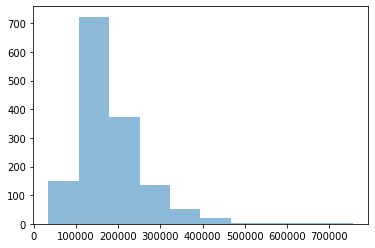

<IPython.core.display.Javascript object>

In [8]:
# Normality
plt.hist(houseprices_df["saleprice"], alpha=0.5)
plt.show()

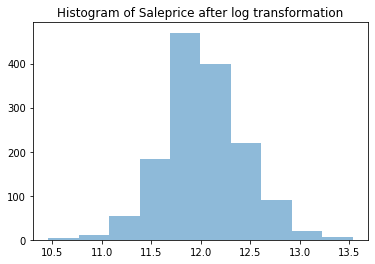

<IPython.core.display.Javascript object>

In [9]:
# Log Transformation
saleprice_transform = np.log(houseprices_df["saleprice"])

# Replacing salesprice with log transformed data
houseprices_df["saleprice"] = saleprice_transform

plt.hist(saleprice_transform, alpha=0.5)
plt.title("Histogram of Saleprice after log transformation")
plt.show()

In [10]:
# Kruskal Wallis Test on a few selected variables
Y = houseprices_df["saleprice"]
X = houseprices_df["overallqual"]
print(
    "The Kruskal Wallist Test results for Overall Quality is: {}".format(
        stats.kruskal(Y, X)
    )
)

Y = houseprices_df["saleprice"]
X = houseprices_df["grlivarea"]
print(
    "The Kruskal Wallist Test results for the Garage Living Area is: {}".format(
        stats.kruskal(Y, X)
    )
)

Y = houseprices_df["saleprice"]
X = houseprices_df["garagecars"]
print(
    "The Kruskal Wallist Test results for the Garage Cars is: {}".format(
        stats.kruskal(Y, X)
    )
)

Y = houseprices_df["saleprice"]
X = houseprices_df["garagearea"]
print(
    "The Kruskal Wallist Test results for the Garage Area is: {}".format(
        stats.kruskal(Y, X)
    )
)

Y = houseprices_df["saleprice"]
X = houseprices_df["totalbsmtsf"]
print(
    "The Kruskal Wallist Test results for the Garage Total Basemet Square Fott is: {}".format(
        stats.kruskal(Y, X)
    )
)

The Kruskal Wallist Test results for Overall Quality is: KruskalResult(statistic=2202.8578164278056, pvalue=0.0)
The Kruskal Wallist Test results for the Garage Living Area is: KruskalResult(statistic=2189.2574420596634, pvalue=0.0)
The Kruskal Wallist Test results for the Garage Cars is: KruskalResult(statistic=2244.812157259343, pvalue=0.0)
The Kruskal Wallist Test results for the Garage Area is: KruskalResult(statistic=1730.4434647781038, pvalue=0.0)
The Kruskal Wallist Test results for the Garage Total Basemet Square Fott is: KruskalResult(statistic=1972.9647728289299, pvalue=0.0)


<IPython.core.display.Javascript object>

In [11]:
# correlation
houseprices_corr = houseprices_df.drop(columns=["saleprice"])
houseprices_corr.corr()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
mssubclass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
lotfrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
lotarea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
overallqual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
overallcond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
yearbuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
yearremodadd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
masvnrarea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201
bsmtfinsf1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
bsmtfinsf2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


<IPython.core.display.Javascript object>

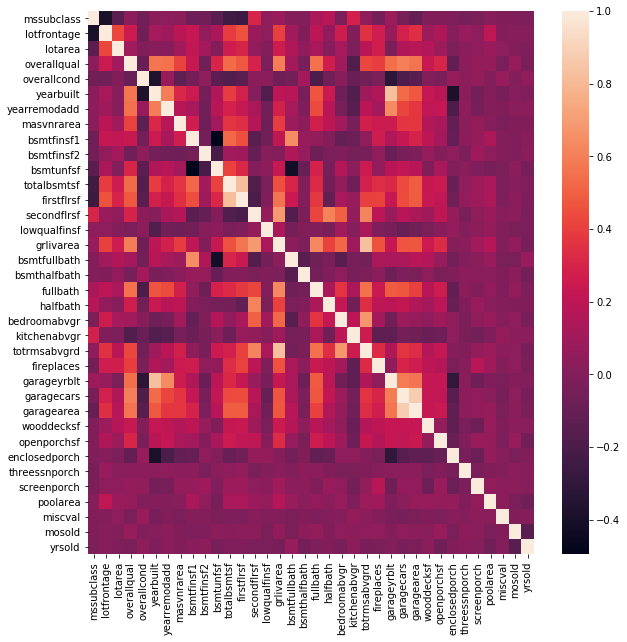

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(houseprices_corr.corr())
plt.show()

In [13]:
houseprices_df.isnull().sum()

mssubclass         0
mszoning           0
lotfrontage      259
lotarea            0
street             0
                ... 
mosold             0
yrsold             0
saletype           0
salecondition      0
saleprice          0
Length: 80, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
houseprices_df.isnull().mean()

mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.177397
lotarea          0.000000
street           0.000000
                   ...   
mosold           0.000000
yrsold           0.000000
saletype         0.000000
salecondition    0.000000
saleprice        0.000000
Length: 80, dtype: float64

<IPython.core.display.Javascript object>

In [15]:
for col in numeric_col:
    houseprices_df.loc[:, col] = houseprices_df.loc[:, col].fillna(
        houseprices_df.loc[:, col].mean()
    )

houseprices_df.isna().sum()

mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
                ..
mosold           0
yrsold           0
saletype         0
salecondition    0
saleprice        0
Length: 80, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
houseprices_df = pd.get_dummies(
    houseprices_df, columns=["mszoning", "street"], drop_first=True
)
houseprices_df.head()

,mssubclass,lotfrontage,lotarea,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,...,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,60,65.0,8450,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,2,2008,WD,Normal,12.247694,0,0,1,0,1
1,20,80.0,9600,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,5,2007,WD,Normal,12.109011,0,0,1,0,1
2,60,68.0,11250,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,9,2008,WD,Normal,12.317167,0,0,1,0,1
3,70,60.0,9550,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,2,2006,WD,Abnorml,11.849398,0,0,1,0,1
4,60,84.0,14260,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,12,2008,WD,Normal,12.429216,0,0,1,0,1


<IPython.core.display.Javascript object>

In [17]:
numeric_col

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saleprice'],
      dtype='object')

<IPython.core.display.Javascript object>

In [18]:
Y = houseprices_df["saleprice"]

X = houseprices_df[numeric_col.drop("saleprice")]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

In [19]:
# Linear Regression
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Predictions
y_predict_train = lrm.predict(X_train)
y_predict_test = lrm.predict(X_test)

# Cross Validation
scores = cross_val_score(lrm, X, Y, cv=5)

print("The Cross-Validation scores are: {}".format(scores))
print(
    "R-squared of the model in the training set is: {}".format(
        lrm.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_predict_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_predict_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_predict_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_predict_test) / y_test)) * 100
    )
)

The Cross-Validation scores are: [0.87975475 0.85265566 0.87791458 0.88477677 0.72507288]
R-squared of the model in the training set is: 0.8652522118627667
-----Test set statistics-----
R-squared of the model in the test set is: 0.8708192962921646
Mean absolute error of the prediction is: 0.11045907905941292
Mean squared error of the prediction is: 0.023653720471440765
Root mean squared error of the prediction is: 0.15379766081264293
Mean absolute percentage error of the prediction is: 0.9316737679726659


<IPython.core.display.Javascript object>

In [20]:
Y = houseprices_df["saleprice"]
X = houseprices_df[numeric_col.drop("saleprice")]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

# Ridge
ridge_regression = RidgeCV(store_cv_values=True)
ridge_regression.fit(X_train, y_train)

# Prediction
y_predict_train = ridge_regression.predict(X_train)
y_predict_test = ridge_regression.predict(X_test)

# Corss Validation
scores = cross_val_score(ridge_regression, X, Y, cv=5)

print("The Cross-Validation scores are: {}".format(scores))
print(
    "R-squared of the model in the training set is: {}".format(
        ridge_regression.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in the test set is: {}".format(
        ridge_regression.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_predict_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_predict_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_predict_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_predict_test) / y_test)) * 100
    )
)

The Cross-Validation scores are: [0.87976336 0.85256218 0.87800541 0.88488613 0.72352117]
R-squared of the model in the training set is: 0.8652520448458865
-----Test set statistics-----
R-squared of the model in the test set is: 0.8708079274998144
Mean absolute error of the prediction is: 0.11045853420699946
Mean squared error of the prediction is: 0.023655802161883947
Root mean squared error of the prediction is: 0.15380442829087837
Mean absolute percentage error of the prediction is: 0.931670343923489


<IPython.core.display.Javascript object>

In [21]:
Y = houseprices_df["saleprice"]
X = houseprices_df[numeric_col.drop("saleprice")]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

# Lasso
lasso_regression = LassoCV()
lasso_regression.fit(X_train, y_train)

# predictions
y_predict_test = lasso_regression.predict(X_test)
y_predict_train = lasso_regression.predict(X_train)

# Cross Validation
scores = cross_val_score(lasso_regression, X, Y, cv=5)

print("The Cross-Validation scores are: {}".format(scores))
print(
    "R-squared of the model in the training set is: {}".format(
        lasso_regression.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in the test set is: {}".format(
        lasso_regression.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_predict_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_predict_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_predict_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_predict_test) / y_test)) * 100
    )
)

The Cross-Validation scores are: [0.82726386 0.77273875 0.81370199 0.76510734 0.53430665]
R-squared of the model in the training set is: 0.7495709443379758
-----Test set statistics-----
R-squared of the model in the test set is: 0.7957354122780402
Mean absolute error of the prediction is: 0.12834221927898176
Mean squared error of the prediction is: 0.03740200603889627
Root mean squared error of the prediction is: 0.1933959824786861
Mean absolute percentage error of the prediction is: 1.083641491327579


<IPython.core.display.Javascript object>

In [22]:
Y = houseprices_df["saleprice"]
X = houseprices_df[numeric_col.drop("saleprice")]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

# ElasticNet
elastic_regression = ElasticNetCV(cv=5)
elastic_regression.fit(X_train, y_train)

# predict
y_predict_train = elastic_regression.predict(X_train)
y_predict_test = elastic_regression.predict(X_test)

# Cross Validation
scores = cross_val_score(elastic_regression, X, Y, cv=5)

print("The Cross-Validation scores are: {}".format(scores))
print(
    "R-squared of the model in the training set is: {}".format(
        elastic_regression.score(X_train, y_train)
    )
)
print("-----Test set statistics-----")
print(
    "R-squared of the model in the test set is: {}".format(
        elastic_regression.score(X_test, y_test)
    )
)
print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_predict_test)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_predict_test)))
print(
    "Root mean squared error of the prediction is: {}".format(
        rmse(y_test, y_predict_test)
    )
)
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_predict_test) / y_test)) * 100
    )
)

The Cross-Validation scores are: [0.82723522 0.77269112 0.81365223 0.76504528 0.53418646]
R-squared of the model in the training set is: 0.749512236191755
-----Test set statistics-----
R-squared of the model in the test set is: 0.7956834697880221
Mean absolute error of the prediction is: 0.12836023346656988
Mean squared error of the prediction is: 0.037411517003802124
Root mean squared error of the prediction is: 0.19342057027059487
Mean absolute percentage error of the prediction is: 1.0837933192080749


<IPython.core.display.Javascript object>



With a Mean absolute percentage error of prediction at 0.93 and a R-Square model of the training set of .86 which is the highest. The Ridge Regression gave us the best numbers which can be used.